In [1]:
import networkx as nx
import numpy as np
import random
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors

In [2]:
class RandomWeightedGraph(nx.Graph):
    def __init__(self, nodes:int):
        super().__init__(nx.bipartite.random_graph(nodes, nodes, 0.5).edges())
        for (u, v) in self.edges():
            self.edges[u,v]['weight'] = np.random.randint(10, 100)
            
    def weight(self, edge):
        return self.edges[edge]['weight']

In [16]:
class MinimumSpanningTree(list):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        self._original_G, self._G, self._root = G.copy(), G, root
        self.counter = 0
        files = glob.glob('../images/kruskal/*')
        for f in files:
            os.remove(f)
        if describe:
            self._setup_describe()

    def _setup_describe(self):
        self._pos = nx.spring_layout(self._G, iterations=10000)
        gray, self._dark_gray = '#eeeeee', '#555555'
        self._node_colors = [gray for n in self._G]
        self._edge_colors = [gray for e in self._G.edges]
        positions = np.array(list(self._pos.values()))
        self._min_x, self._min_y = np.min(positions, axis=0) - 0.1
        self._max_x, self._max_y = np.max(positions, axis=0) + 0.1

    def _plot_graphs(self, graphs: list, title: str):
        n, graph_size, graph_per_row = len(graphs) + 1, 3, 4
        w, h = min(n, graph_per_row), np.ceil(n / graph_per_row)
        plt.figure(figsize=(graph_size * w, graph_size * h))
        plt.suptitle(title)
        for i, ((G, title), color) in enumerate(
                zip(graphs, ['r', 'c', 'm', 'pink', 'orange', 'b', 'g', 'y'])):
            ax = plt.subplot(h, w, i + 1)
            ax.set_xlim(self._min_x, self._max_x)
            ax.set_ylim(self._min_y, self._max_y)
            ax.set_title(title)
            nx.draw(
                self._original_G,
                pos=self._pos,
                with_labels=True,
                font_color="#999999",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'),
                node_color=self._node_colors,
                edge_color=self._edge_colors)
            nx.draw(
                G,
                pos=self._pos,
                with_labels=True,
                font_color="#222222",
                node_color=color,
                edge_color=color)
            nx.draw_networkx_edge_labels(
                self._original_G,
                pos=self._pos,
                font_color="#777777",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'))

        ax = plt.subplot(h, w, i + 2)
        ax.set_xlim(self._min_x, self._max_x)
        ax.set_ylim(self._min_y, self._max_y)
        nx.draw(
            self._original_G,
            pos=self._pos,
            with_labels=True,
            font_color="#999999",
            edge_labels=nx.get_edge_attributes(self._original_G, 'weight'),
            node_color=self._node_colors,
            edge_color=self._edge_colors)

        for (G, title), color in zip(
                graphs, ['r', 'b', 'c', 'm', 'g', 'y', 'pink', 'orange']):
            nx.draw(
                G,
                pos=self._pos,
                with_labels=True,
                font_color="#222222",
                node_color=color,
                edge_color=color)

        nx.draw_networkx_edge_labels(
            self._original_G,
            pos=self._pos,
            font_color="#777777",
            edge_labels=nx.get_edge_attributes(self._original_G, 'weight'))

        plt.savefig("../images/kruskal/{c}.png".format(c=self.counter))
        self.counter+=1
        plt.show()

    def _describe_start(self, root: int):
        tree = nx.Graph()
        tree.add_node(root)
        colors = ['r' for n in self._original_G]
        self._plot_graphs([(self._original_G, colors, "Initial Graph"),
                           (tree, colors, "Initial Tree")],
                          "Initial Conditions")

In [17]:
class KruskalTree(MinimumSpanningTree):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        super().__init__(G, root, describe=describe)
        [self.append([(v, v)]) for v in G]
    
    def run(self):
        weights = nx.get_edge_attributes(G, 'weight')
        self._edges = sorted(weights, key=weights.get, reverse=True)
        while not self._is_spanning():
            self.iteration()
    
    def iteration(self):
        edge = u, v = self._edges.pop()
        set_u = self._get_node_component(u)
        set_v = self._get_node_component(v)
        if set_u != set_v:
            self[set_u] += self[set_v] + [(u, v)]
            del self[set_v]
        return set_u, set_v, u, v
        

    def _get_node_component(self, node: int):
        for i, component in enumerate(self):
            for edge in component:
                if node in edge:
                    return i
        return None

    def _is_spanning(self):
        return len(self) == 1


In [18]:
class GraphicalKruskalTree(KruskalTree):
    def __init__(self, G: nx.Graph, root: int):
        super().__init__(G, root, True)

    def run(self):
        self._plot_graphs(
            [(nx.Graph(c), "".format(c=i)) for i,c in enumerate(self)],
            "Initial conditions")
        self._i=0
        super().run()

    def iteration(self):
        set_u, set_v, u, v = super().iteration()
        self._plot_graphs(
            [(nx.Graph(c), "".format(j=j))
             for j, c in enumerate(self)],
            "Iteration {i}: Merging component {u} with component {v} via edge ({a}, {b})"
            .format(i=self._i, u=set_u, v=set_v, a=u, b=v))
        self._i+=1
    
    def _create_iteration_graph(self, costs: dict, neighbors: list,
                                node: int) -> tuple:
        iteration = nx.Graph()
        [iteration.add_node(v) for v in [*costs, node, *neighbors]]
        colors = [
            'g' if v in neighbors else 'm' if v == node else 'c'
            for v in iteration
        ]
        return iteration, colors

In [33]:
seed = 236
random.seed(seed)
np.random.seed(seed)
G = RandomWeightedGraph(3)
root = 1
end = 4

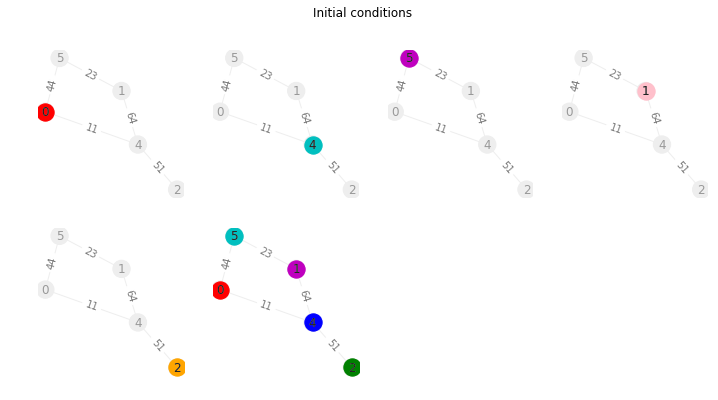

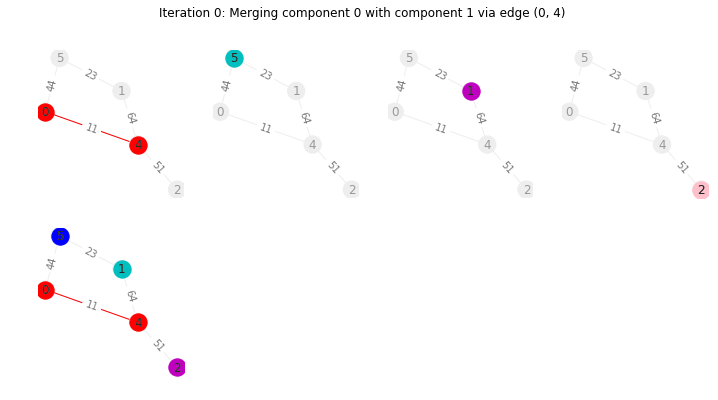

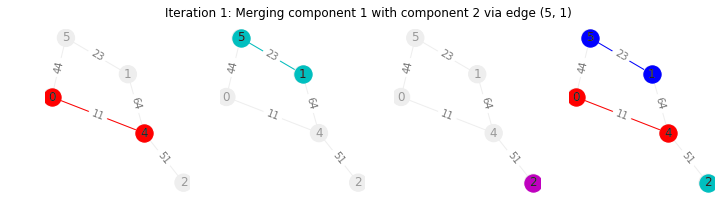

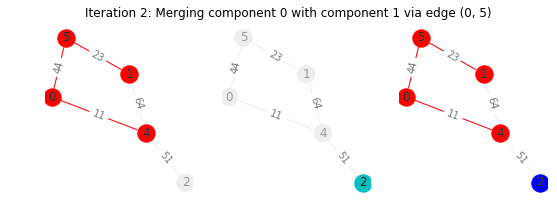

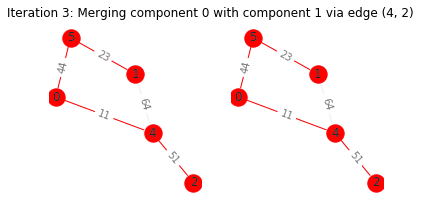

In [34]:
GraphicalKruskalTree(G, root).run()